In [1]:
# imports
from tueplots import bundles
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile



In [90]:
plt.rcParams.update(bundles.neurips2022(usetex=False))

In [2]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"
SWEEP_ID = "z5hrto4y"


In [96]:
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
sweep_runs = sweep.runs

In [97]:
data = []
filename = f"moebius_sweep_data_{SWEEP_ID}.csv"
max_dim = -1
if not isfile(filename):
    for run in sweep_runs:

        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary = run.summary._json_dict

        if "epoch" in summary.keys() and summary["epoch"] >=180:
                #or (run.state == 'finished' or ('decoder_var' in run.config.keys() and run.config['decoder_var']>= 0.1)) and f'Metrics/val/latent_statistics.latent_variance_0' in run.history().keys():

            # .config contains the hyperparameters.
            #  We remove special values that start with _.
            config = {k: v for k,v in run.config.items()
                 if not k.startswith('_')}

            dim = config['latent_dim']
            sigmas = run.history(keys=[f'Metrics/val/latent_statistics.latent_variance_{i}' for i in range(dim)]).iloc[-1].to_numpy()[1:]
            col_norms_sq = [run.summary._json_dict[f"Metrics/val/col_norm_{i}"]**2 for i in range(dim)]

            mcc = summary['Metrics/val/mcc']
            mcc_history = run.history(keys=[f'Metrics/val/mcc'])
            max_mcc_step, max_mcc = mcc_history.max()


            cima = summary['Metrics/val/cima']
            cima_history = run.history(keys=[f'Metrics/val/cima'])
            min_cima_step, min_cima = cima_history.min()

            mcc4min_cima = mcc_history[mcc_history._step == int(min_cima_step)]['Metrics/val/mcc'][0]
            cima4max_mcc = cima_history[cima_history._step == int(max_mcc_step)]['Metrics/val/cima'].tolist()[0]

            gamma_square = 1. / config['decoder_var']
            prior = config['model.prior']

            neg_elbo = summary['Metrics/val/neg_elbo']
            neg_elbo_history = run.history(keys=[f'Metrics/val/neg_elbo'])
            min_neg_elbo_step, min_neg_elbo = neg_elbo_history.min()

            mcc4min_neg_elbo = mcc_history[mcc_history._step == int(min_neg_elbo_step)]['Metrics/val/mcc'][0]
            cima4min_neg_elbo = cima_history[cima_history._step == int(min_neg_elbo_step)]['Metrics/val/cima'][0]

            rec_loss = summary['Metrics/val/rec_loss']
            kl_loss = summary['Metrics/val/kl_loss']
            rhs = (1./(float(prior=="gaussian")+gamma_square*np.array(col_norms_sq)))
            if dim > max_dim:
                max_dim = dim

            data.append([run.name, dim, gamma_square, neg_elbo, kl_loss, rec_loss, prior, cima, mcc, min_cima, min_cima_step, cima4max_mcc, cima4min_neg_elbo,
                         max_mcc, max_mcc_step, mcc4min_cima, mcc4min_neg_elbo,  *sigmas, *col_norms_sq, *rhs])


    runs_df = pd.DataFrame(data, columns=["name", "dim", "gamma_square", "neg_elbo", "kl_loss", "rec_loss", "prior", "cima", "mcc", "min_cima", "min_cima_step",  "cima4max_mcc", "cima4min_neg_elbo", "max_mcc", "max_mcc_step",  "mcc4min_cima", "mcc4min_neg_elbo", *[f"sigma_{i}" for i in range(max_dim)],
                                          *[f"col_norm_sq_{i}" for i in range(max_dim)], *[f"rhs_{i}" for i in range(max_dim)]  ] ).fillna(0)
    # runs_df.to_csv(filename)
else:
    runs_df = pd.read_csv(filename)

In [98]:
runs_df

,name,dim,gamma_square,neg_elbo,kl_loss,rec_loss,prior,cima,mcc,min_cima,...,mcc4min_neg_elbo,sigma_0,sigma_1,sigma_2,col_norm_sq_0,col_norm_sq_1,col_norm_sq_2,rhs_0,rhs_1,rhs_2
0,ruby-sweep-152,3,1000.0,-4.752517,-1.417089,6.169606,gaussian,0.000395,0.727537,0.000241,...,0.044802,0.030964,0.033913,0.036732,0.016822,0.015320,0.015009,0.056112,0.061274,0.062465
1,playful-sweep-149,3,10.0,-0.658188,-0.000003,0.658191,gaussian,1.298975,0.052294,0.129602,...,0.048649,0.247563,0.254378,0.353321,0.000009,0.000010,0.000003,0.999907,0.999904,0.999968
2,lyric-sweep-148,3,10.0,-0.658172,-0.000005,0.658177,gaussian,3.987740,0.057683,0.259372,...,0.054953,0.091756,0.322076,0.132659,0.000016,0.000010,0.000018,0.999838,0.999902,0.999817
3,young-sweep-142,3,10000000.0,2.364881,-19.199873,16.834991,gaussian,0.031388,0.938983,0.017474,...,0.053537,0.000001,0.000003,0.000002,0.068719,0.033520,0.055826,0.000001,0.000003,0.000002
4,astral-sweep-141,3,10000000.0,15.220965,-19.135801,3.914838,gaussian,0.116171,0.711750,0.116171,...,0.050677,0.000002,0.000002,0.000002,0.048271,0.048421,0.067185,0.000002,0.000002,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,icy-sweep-21,3,10000000.0,2.854864,-19.496193,16.641328,gaussian,0.181296,0.660679,0.181296,...,0.059109,0.000001,0.000003,0.000001,0.082229,0.031206,0.091377,0.000001,0.000003,0.000001
95,eager-sweep-20,3,10000000.0,0.150864,-18.791946,18.641080,gaussian,0.070250,0.955443,0.013581,...,0.053484,0.000001,0.000003,0.000001,0.097097,0.034967,0.080638,0.000001,0.000003,0.000001
96,vocal-sweep-19,3,1000000.0,0.267476,-14.809995,14.542519,gaussian,0.008929,0.691305,0.008929,...,0.057073,0.000015,0.000015,0.000015,0.064468,0.068604,0.068598,0.000016,0.000015,0.000015
97,dandy-sweep-18,3,1000000.0,-1.652508,-13.933839,15.586348,gaussian,0.006254,0.861100,0.005839,...,0.056333,0.000021,0.000021,0.000036,0.047117,0.048213,0.027143,0.000021,0.000021,0.000037


$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

In [99]:
runs_df[[ "mcc", "gamma_square"]].groupby("gamma_square").describe()

mcc                                                    \
             count      mean       std       min       25%       50%   
gamma_square                                                           
1.000000e+01  11.0  0.052227  0.002485  0.048861  0.050888  0.051912   
1.000000e+03  19.0  0.651958  0.073934  0.537665  0.567786  0.682387   
1.000000e+04  19.0  0.804703  0.095310  0.660606  0.738207  0.779193   
1.000000e+05  19.0  0.825038  0.080022  0.685043  0.759150  0.827510   
1.000000e+06   5.0  0.842164  0.092292  0.691305  0.856142  0.857528   
1.000000e+07   8.0  0.826489  0.103160  0.660679  0.780367  0.826010   
1.000000e+08   5.0  0.802416  0.116508  0.652155  0.725822  0.816868   
1.000000e+10  13.0  0.812841  0.095056  0.652677  0.729356  0.829415   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  0.052443  0.057683  
1.000000e+03  0.717294  0.740419  
1.000000e+04  0.874936  0.951662  
1.000000e+05  0.880262  0.957422  
1.000000e+06  0.861100  0.944746  
1.000000e+07  0.902095  0.955443  
1.000000e+08  0.869341  0.947894  
1.000000e+10  0.868320  0.947915

In [100]:
runs_df[[ "max_mcc", "gamma_square"]].groupby("gamma_square").describe()

max_mcc                                                    \
               count      mean       std       min       25%       50%   
gamma_square                                                             
1.000000e+01    11.0  0.059850  0.001839  0.057550  0.058294  0.059246   
1.000000e+03    19.0  0.681775  0.067921  0.563657  0.618223  0.721642   
1.000000e+04    19.0  0.814706  0.093298  0.663129  0.754368  0.794485   
1.000000e+05    19.0  0.829724  0.078259  0.690243  0.764691  0.830704   
1.000000e+06     5.0  0.842349  0.092040  0.692047  0.856142  0.857528   
1.000000e+07     8.0  0.826538  0.103099  0.660679  0.780465  0.826010   
1.000000e+08     5.0  0.803362  0.116699  0.652155  0.725822  0.821354   
1.000000e+10    13.0  0.814225  0.095540  0.652677  0.729356  0.829415   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  0.061395  0.063043  
1.000000e+03  0.738738  0.754540  
1.000000e+04  0.886120  0.952010  
1.000000e+05  0.880450  0.957422  
1.000000e+06  0.861100  0.944928  
1.000000e+07  0.902095  0.955443  
1.000000e+08  0.869585  0.947894  
1.000000e+10  0.876237  0.947915

In [101]:
runs_df[[ "cima", "gamma_square"]].groupby("gamma_square").describe()

cima                                                    \
             count      mean       std       min       25%       50%   
gamma_square                                                           
1.000000e+01  11.0  1.994848  0.945756  0.853528  1.279189  1.848076   
1.000000e+03  19.0  0.001890  0.000801  0.000395  0.001545  0.001897   
1.000000e+04  19.0  0.000426  0.000197  0.000111  0.000300  0.000396   
1.000000e+05  19.0  0.000203  0.000112  0.000021  0.000128  0.000186   
1.000000e+06   5.0  0.006435  0.005584  0.001152  0.001357  0.006254   
1.000000e+07   8.0  0.113751  0.068886  0.031388  0.064358  0.097818   
1.000000e+08   5.0  0.102261  0.087999  0.032412  0.037142  0.056608   
1.000000e+10  13.0  0.099980  0.058980  0.029882  0.055974  0.091960   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  2.570301  3.987740  
1.000000e+03  0.002629  0.002993  
1.000000e+04  0.000515  0.000947  
1.000000e+05  0.000283  0.000405  
1.000000e+06  0.008929  0.014482  
1.000000e+07  0.166281  0.223481  
1.000000e+08  0.150983  0.234161  
1.000000e+10  0.135908  0.234348

In [103]:
runs_df[[ "neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

neg_elbo                                                     \
                count         mean          std         min          25%   
gamma_square                                                               
1.000000e+01     11.0    -0.657941     0.000235   -0.658188    -0.658126   
1.000000e+03     19.0    -4.751997     0.017001   -4.774455    -4.765416   
1.000000e+04     19.0    -4.674331     0.098136   -4.789461    -4.753610   
1.000000e+05     19.0    -4.084388     0.457678   -4.607050    -4.366480   
1.000000e+06      5.0    -1.297653     1.947191   -3.856509    -2.225483   
1.000000e+07      8.0     5.585691     5.927583    0.150864     2.056439   
1.000000e+08      5.0    29.997843    14.141944    8.602931    25.809282   
1.000000e+10     13.0  5411.131571  4361.013459  583.680076  1994.218029   

                                                      
                      50%          75%           max  
gamma_square                                          
1.000000e+01    -0.658044    -0.657728     -0.657602  
1.000000e+03    -4.754372    -4.744926     -4.712541  
1.000000e+04    -4.674776    -4.636056     -4.363001  
1.000000e+05    -4.205534    -3.926297     -3.005462  
1.000000e+06    -1.652508     0.267476      0.978756  
1.000000e+07     2.609873     8.000562     15.220965  
1.000000e+08    30.189796    41.623431     43.763776  
1.000000e+10  3277.097432  9750.116378  12858.675385

In [108]:
df_rhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "rhs" in col]].stack().droplevel(1), columns=["rhs"])
df_lhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "sigma" in col]].stack().droplevel(1), columns=["lhs"])
df_rhs_lhs_gamma_sq = df_rhs.merge( df_lhs, left_index=True, right_index=True).merge(runs_df["gamma_square"], left_index=True, right_index=True)

In [93]:
def create_violinplot(groups, xlabel, ylabel, xticklabels, figsize=(6,3), filename=None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    vp= plt.violinplot(groups, showmedians=True)
    for el in vp['bodies']:
        el.set_facecolor('#1A85FF')
        el.set_edgecolor('black')
        el.set_linewidth(1.5)
        el.set_alpha(.9)
    for pn in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
        vp_ = vp[pn]
        vp_.set_edgecolor('black')
        vp_.set_linewidth(1)
    ax.set_xticklabels(xticklabels)
    # plt.locator_params(axis='y', nbins=5)
    # plt.yticks(fontsize=24)
    # plt.ylim([0, 0.5])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if filename is not None:
        plt.savefig(f"{filename}.svg")

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/213047492.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


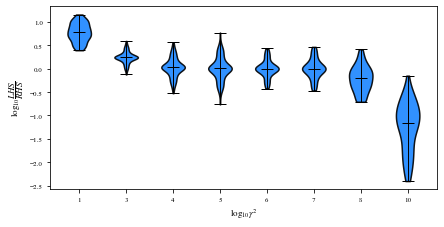

In [110]:
groups = [np.log10((g.rhs/g.lhs).abs()) for _, g in df_rhs_lhs_gamma_sq.groupby("gamma_square")]
create_violinplot(groups, '$\log_{10}\gamma^2$', '$\log_{10}\dfrac{LHS}{RHS}$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="opt_sigma_gamma")

In [184]:
elbo_filter = runs_df[[ "neg_elbo", "gamma_square"]].groupby("gamma_square").describe()['neg_elbo']['75%']
groups = [g for _, g in runs_df[[ "neg_elbo", "mcc", "cima", "gamma_square"]].groupby("gamma_square")]
gg_mcc = [g[g.neg_elbo <= threshold].mcc  for g, threshold in zip(groups, elbo_filter)]
gg_cima = [g[g.neg_elbo <= threshold].cima  for g, threshold in zip(groups, elbo_filter)]
gg_gamma = [g[g.neg_elbo <= threshold].gamma_square  for g, threshold in zip(groups, elbo_filter)]

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/213047492.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


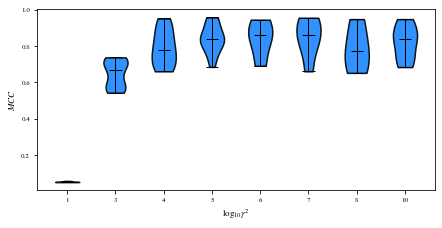

In [185]:
create_violinplot(gg_mcc, '$\log_{10}\gamma^2$', '$MCC$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="mcc_vs_gamma")

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/213047492.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


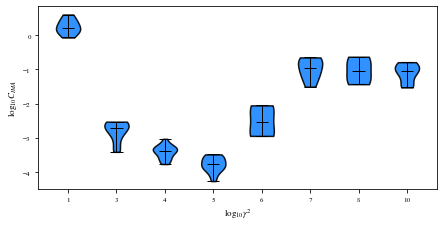

In [186]:
create_violinplot([np.log10(g) for g in gg_cima], '$\log_{10}\gamma^2$', '$\log_{10}C_{IMA}$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="cima_vs_gamma")

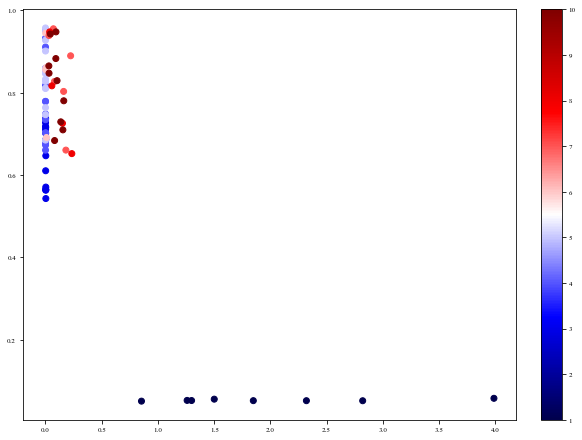

In [177]:
plt.figure(figsize=(8,6))
plt.scatter([item for sublist in gg_cima for item in sublist],[item for sublist in gg_mcc for item in sublist], c=[np.log10(item) for sublist in gg_gamma for item in sublist], cmap="seismic")
plt.colorbar()

In [48]:
def violin_by_prior(gauss_data, laplace_data, uniform_data, xticks, xlabel, ylabel,  offset, filename, figsize=(8,6), log=False):

    plt.figure(figsize=figsize)
    vp_gauss = plt.violinplot([np.log10(i) if log is True else i for i in gauss_data], positions=xticks)
    vp_laplace = plt.violinplot([np.log10(i) if log is True else i for i in laplace_data], positions=-offset+xticks)
    vp_uniform= plt.violinplot([np.log10(i) if log is True else i for i in uniform_data], positions=offset+xticks)
    plt.legend([vp_gauss['bodies'][0],vp_laplace['bodies'][0], vp_uniform['bodies'][0]], ['gaussian', 'laplace', 'uniform'], loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xticks)
    # plt.tight_layout()
    plt.savefig(filename)

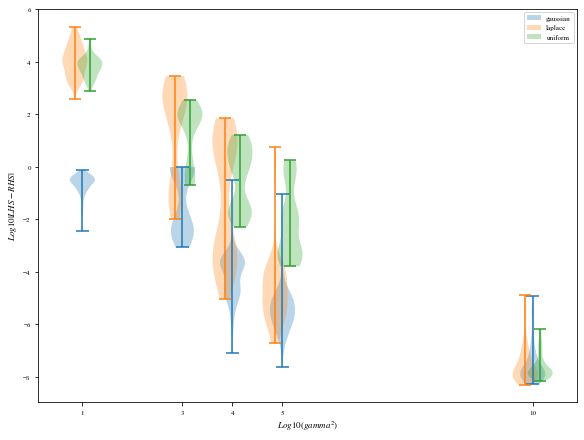

In [49]:
violin_by_prior(lhs_rhs_vs_gamma_gauss, lhs_rhs_vs_gamma_laplace, lhs_rhs_vs_gamma_uniform,  np.unique(np.log10(gamma_uniform_ext)), '$Log10(gamma^2)$', '$Log10|LHS-RHS|$',  0.15, 'opt_sigma_vs_gamma', log=True)

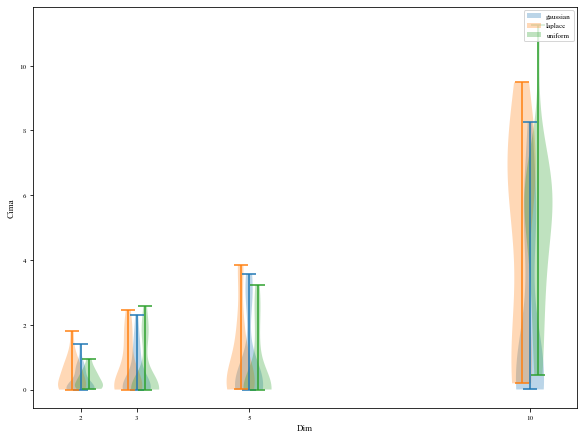

In [32]:
violin_by_prior(cima_vs_dim_gauss, cima_vs_dim_laplace, cima_vs_dim_uniform,  np.unique(dim), 'Dim', 'Cima',  0.15, 'cima_vs_dim')

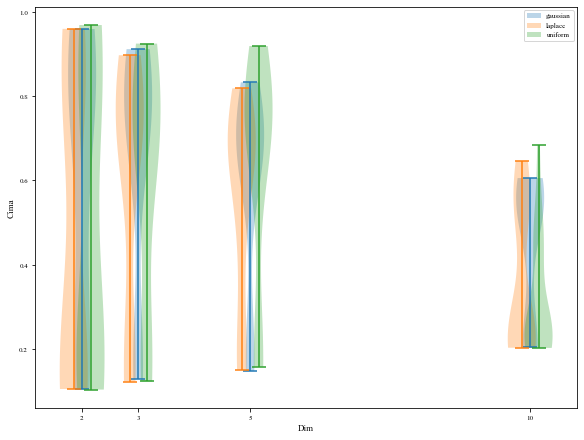

In [33]:
violin_by_prior(mcc_vs_dim_gauss, mcc_vs_dim_laplace, mcc_vs_dim_uniform,  np.unique(dim), 'Dim', 'Cima',  0.15, 'mcc_vs_dim')